# CNV analysis
## Notebook 1
This notebook takes a table of genomic bin coverage counts and processes it to identify polymorphic bins and obtain  dosage values per bin. It then correlates bin to bin value, identifying strong LD between genomic positions. 
### Experimental population
The input table is from a segregating population, such as an F2 or the dihaploids produced by a potato haploid induction cross. An example population is provided here. It was derived from this cross:

**Solanum tuberosum var. Desiree (4x) x S. tuberosum phureja var. IvP48 (2x)**

the progeny individuals were sequenced and subjected to bin-by-sam analysis. These individuals had a diploid genome content and represent maternal gametes since the paternal genome was eliminated. Reads mapping in a given bin were standardized by the mean counts obtained in the same bin. 
The table can be obtained here: https://ndownloader.figshare.com/files/20476278

### Algorithm
This is a not a use-ready application. Some cells may be optional or used for certain ad hoc purposes. The notebook is annotated to facilitate modification and should be used one cell at a time.  
#### Step 1

To assess Linkage Disequilibrium between bins, we used this Python script which analyzes the sequence dosage, identifies polymorphic bins, identifies dosage states (peaks), and carries out a Fisher Exact test between pairs of CN states.  For example, to test if BIN1-CN1 was correlated to BIN100-CN3, the following four line sets were compared:

>observed lines in BIN1-CN1 : observed lines not in BIN1-CN1 | expected lines in BIN1-CN1 : expected lines not in BIN1-CN1

Expected was derived from the assumption of complete independence. For example, for 375 polymorphic bins, this would entail ~975,000 comparisons. Many of these are not independent because they are from tightly linked bins and half are reciprocal. We controll the False Discovery Rate setting it to 0.05 by using the Benjamini-Hochberg procedure, which we apply using the conservative assumption that the number of indepedent test is: 

>(total comparisons - self-comparisons)/2

This is to account for the reciprocal nature of the pairwise comparison. Bins that engage in at least one statistically significant correlation are deemed in LD. 

### Author
---
Luca Comai  
Plant Biology and Genome Center  
University of California Davis 
Davis, CA  95616  
email: lcomai@ucdavis.edu  
http://comailab.genomecenter.ucdavis.edu/

---

# Software
Run on Python 3.5+. Make sure that all the packages in this cell are installed. I recommend the use of Anaconda (https://www.anaconda.com/) as a package manager. For example, to install peakutils follow instructions at https://anaconda.org/conda-forge/peakutils.

In [33]:
# use iPython magic notation to make the plots appear inline
%matplotlib inline
# import all needed libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats, integrate, interpolate
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import numpy as np
import peakutils
from peakutils.plot import plot as pplot
from statsmodels.api import stats as stt 
import random
from datetime import date


In [34]:
# set date for time stamping of file names
today = date.today().isoformat()
today 

'2020-02-04'

# Step 1. Load and prepare the input table for processing
The input table is generated by counting reads in genomic intervals (bins). This can be done using [Bin-by-SAM](http://comailab.genomecenter.ucdavis.edu/index.php/Bin-by-sam) or equivalent program. The count is standardized by taking the fraction of mapped reads that aligned to a bin of interest for that sample, normalizing it to the corresponding fraction from the same interval in the relevant parent (or use the mean of all individuals), and multiplying the resulting value by the expected ploidy, in this case 2. The table has the following column headers:
* Chromosome 
* Start, Start of genomic bean
* End, End of enomic bins used. Typically, 1 mbase or 100Kb each.
* Accession 1.->Values for each bin centered on 2. 
* Accession 2.->Same
* Etc.

The following rows:
* Chromosomal Bin 1
* Chromosomal Bin 2
* and so on in progressive order of chromosome and nuc position

For the program to run, the input table must be massaged to look exactly like the one below. For example, it must use "chr01" not "ch01", bins must start on nuc 1 and the end on nuc 0. Failure to do so will break downstream steps that rely on correct structure of the input table. 

| Chrom  |  Strt | End | LOP1  | LOP2  | LOP3  | LOP4  |
|---|---|---|---|---|---|---|
| chr01  |   1 | 100000 |  2.2  | 2.0  |  2.0 |  3.0 |
| chr01 |  100001 | 200000  |  1.95 |  3.0 | 1.95 |  3.0 |
| chr01 |  200001 | 300000  | 2.0  | 2.0  |  2.5. |  1.95 |l

Once in the notebook, the table will be referred to as a dataframe. The output of this is a table of clean dosages

| Bin | LOP1  | LOP2  | LOP3  | LOP4  |
|---|---|---|---|---|
| chr01_1 |  2.2  | 2.0  |  2.0 |  3.0 |
| chr01_100001 |  1.95 |  3.0 | 1.95 |  3.0 |
| chr01_200001 |  2.0  | 2.0  |  2.5. |  1.95 |l



In [3]:
# load input table
# copy YOUR pathname of pop_2x.csv file to this variable
# in a mac finder window, control click on the table name
# then press option and select "copy name as path" in the contextual menu that opens up
pop_main = pd.read_csv('/Users/lucacomai/Box/Analysis_jupyter/generic_cnv_analysis_with_latest_notebooks/2x_2020-01-08.csv')
#pop_main = pd.read_csv(pop)
# index was bin # and becomes column in the loaded version: drop it
#pop_main.drop('bin',axis=1,inplace=True)
pop_main.head()


,chrom,start,end,2x-BB-10,2x-BB-102,2x-BB-110,2x-BB-116,2x-BB-119,2x-BB-12,2x-BB-158,...,2x-BB-320,2x-BB-35,2x-BB-36,2x-BB-38,2x-BB-41,2x-BB-51,2x-BB-56,2x-BB-60,2x-BB-85,2x-BB-92
0,chr01,0.0,1000000.0,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,...,2.064400,2.281464,2.056352,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393
1,chr01,1000000.0,2000000.0,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,...,2.014076,1.920225,1.965836,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926
2,chr01,2000000.0,3000000.0,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,...,2.073330,1.974799,1.908027,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441
3,chr01,3000000.0,4000000.0,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,...,1.964451,2.052592,1.833749,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170
4,chr01,4000000.0,5000000.0,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,...,2.237613,2.247931,2.051870,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816


## Input table
This table has multiple "problems" that need fixing. Your own table may require different fixes and this part provides examples of fixing steps. You need to know a little bit of python and pandas to adapt them to your own use, but it is not that hard. Note that the table has 57 columns with the raw read count (these are dumped in tyeh following steps, but could be useful for certain analyses) and 57 with the standardized dosage value. 

In [4]:
# Name the population with a short string. This will be added to the name of the different
# files that are printed throughout execution of this book. 
pop_name = 'bb'


In [5]:
# as noted, some of the data columns may contain raw data. In virtually all cases, these columns average to >50
# because bins with fewer than 100 counts are not reliable and the bin size would have to be increased
# I use this property to identify these columns: I make a list of columns that have mean > 50 
# get a series of all data column names
# this cell does not hurt a table that is already clean, i.e. has no raw data
my_datacols = pop_main.columns[3:]
# initiate an empty list
my_dropcols = []
# iterate through the columns to find those that have high means
for col in my_datacols:
    if pop_main[col].mean()>50:
        my_dropcols.append(col)
    else:
        continue
len(my_dropcols)


0

In [6]:
# use the list of raw value columns to drop them
# this cell does not hurt a table that is already clean, i.e. has no raw data
pop_main.drop(columns=my_dropcols, inplace=True)
# compare table resulting shape to starting shape
pop_main.shape


(731, 87)

In [7]:
# make the column name short and simple. Remove invariable letters or number leaving 
# what is informative. In this case, the last 3 digits. I keep the 0 just for fun
my_datacols = pop_main.columns[3:]
# identify non-data columns, i.e. those that show the chr and position of bin
#my_chrcols = list(pop_main.columns[:3])
# or use standard columns names
my_chrcols = ['Chrom','Start','End']
# trim col name to core. Adjust this trimming to fit the type of name used 
my_datacols = [i[6:10] for i in my_datacols]
# reassemble the new columns
my_cols = my_chrcols+my_datacols
# take a look if needed
#my_cols[:10]
# rename columns in dataframe
pop_main.columns = my_cols
pop_main.head()


,Chrom,Start,End,10,102,110,116,119,12,158,...,320,35,36,38,41,51,56,60,85,92
0,chr01,0.0,1000000.0,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,...,2.064400,2.281464,2.056352,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393
1,chr01,1000000.0,2000000.0,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,...,2.014076,1.920225,1.965836,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926
2,chr01,2000000.0,3000000.0,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,...,2.073330,1.974799,1.908027,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441
3,chr01,3000000.0,4000000.0,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,...,1.964451,2.052592,1.833749,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170
4,chr01,4000000.0,5000000.0,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,...,2.237613,2.247931,2.051870,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816


In [8]:
# OPTIONAL: If your table "Start" ends in 1, SKIP THIS
# the example table has both "start" and "end" end on 0
# set "start" to end on 1. 
pop_main.Start = pop_main.Start.map(lambda x: x+1)
# get rid of decimal
pop_main.Start = pop_main.Start.astype(int)
pop_main.End = pop_main.End.astype(int)
pop_main.head()

,Chrom,Start,End,10,102,110,116,119,12,158,...,320,35,36,38,41,51,56,60,85,92
0,chr01,1,1000000,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,...,2.064400,2.281464,2.056352,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393
1,chr01,1000001,2000000,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,...,2.014076,1.920225,1.965836,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926
2,chr01,2000001,3000000,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,...,2.073330,1.974799,1.908027,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441
3,chr01,3000001,4000000,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,...,1.964451,2.052592,1.833749,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170
4,chr01,4000001,5000000,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,...,2.237613,2.247931,2.051870,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816


In [9]:
# OPTIONAL: rename the Chrom strings in col.1 to be simple "chr01, chr02", etc)
# pop_main['Chrom'] = 'chr'+pop_main['Chrom'].str[-2:]
# make new column displaying an inclusive bin name
# OPTIONAL:
# also, get rid of the ".0" by slicing. IF YOUR "START" does not have .0, SKIP THIS
pop_main["Bin"] = pop_main['Chrom']+"_"+pop_main.Start.astype(str)
# make a bin order column starting with 1
pop_main['bino'] = pop_main.index+1
pop_main.head()

,Chrom,Start,End,10,102,110,116,119,12,158,...,36,38,41,51,56,60,85,92,Bin,bino
0,chr01,1,1000000,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,...,2.056352,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393,chr01_1,1
1,chr01,1000001,2000000,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,...,1.965836,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926,chr01_1000001,2
2,chr01,2000001,3000000,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,...,1.908027,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441,chr01_2000001,3
3,chr01,3000001,4000000,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,...,1.833749,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170,chr01_3000001,4
4,chr01,4000001,5000000,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,...,2.051870,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816,chr01_4000001,5


In [10]:
# make a dataframe that has the bin information
chr_bin_df = pop_main.loc[:,['Chrom', 'Start', 'End','Bin','bino']]
chr_bin_df.sort_values(by = ['bino'])
chr_bin_df.set_index('Bin', inplace = True)
#chr_bin_df.rename_axis('bin_n', inplace=True)
#pop_2xp.shape
#731, 86
chr_bin_df.tail()


,Chrom,Start,End,bino
Bin,,,,
chr12_57000001,chr12,57000001,58000000,727
chr12_58000001,chr12,58000001,59000000,728
chr12_59000001,chr12,59000001,60000000,729
chr12_60000001,chr12,60000001,61000000,730
chr12_61000001,chr12,61000001,61165649,731


In [11]:
chr_bin_df.to_pickle("chr_bin_"+pop_name+'_'+today+'.pckle')

In [12]:
# determine the number and name of the chromosomes
df_val = pd.DataFrame(chr_bin_df["Chrom"].value_counts())
# the resulting table lists the number of occurrences
# this counts bins/chrom and puts them in order of size (bin numbers)
df_val

,Chrom
chr01,89
chr04,73
chr03,63
chr12,62
chr09,62
chr10,60
chr06,60
chr07,57
chr08,57
chr05,53


In [13]:
# how to obtain chrom length in bin
df_val.at['chr03',"Chrom"]

63

## Dataframe of chromosomes and bins
I am splitting the information in the original input table. The "chr_bin_df" will be used to store information about the bins. The 'bino' column provides a numerical identifier of each bin starting with 1. 

In [14]:
# Use the chr_bin_df to identify chromosome start points, i.e. get rightmost chromosomal bin
pcb = chr_bin_df.loc[:,['Chrom','bino']]
pgr = pcb.groupby('Chrom').min()
chr_start = list(pgr['bino'])
# add the end bin to cap the series off
chr_start.append(len(pop_main))
chr_start

[1, 90, 139, 202, 275, 328, 388, 445, 502, 564, 624, 670, 731]

In [15]:
# pickle the bin information. Pickle data files are python specific
# the keep intact all attributes such as numbers
chr_bin_df.to_pickle(pop_name+'_chr_bin_'+today+'.pckle')


In [16]:
# In the data table, put the Bin column first, drop the original first three
# make a list that has the correct column names and order
old_cols = pop_main.columns
#old_cols[3:-1]
new_col_order = list(old_cols[3:-2])
#trim column name
new_col_order.insert(0,'Bin')
new_col_order[:7]


['Bin', '10', '102', '110', '116', '119', '12']

In [17]:
# change the df to the new column names, at the same time dropping starts and ends 
pop_main = pop_main[new_col_order]
pop_main.head()


,Bin,10,102,110,116,119,12,158,163,167,...,320,35,36,38,41,51,56,60,85,92
0,chr01_1,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,1.939870,1.817495,...,2.064400,2.281464,2.056352,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393
1,chr01_1000001,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,1.992071,1.936170,...,2.014076,1.920225,1.965836,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926
2,chr01_2000001,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,1.880172,1.915661,...,2.073330,1.974799,1.908027,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441
3,chr01_3000001,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,1.892276,1.860424,...,1.964451,2.052592,1.833749,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170
4,chr01_4000001,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,2.087952,2.004899,...,2.237613,2.247931,2.051870,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816


In [18]:
# pickle this entry table for future use
pop_main.to_pickle(pop_name+'_step2ready_'+today+'.pckle')


#  Step 2. Test peak finding method on selected CNV
This uses a clean input table and tests peak finding parameters. One can avoid most of the step above and start here by opening the _step2ready_ pickled table, if available. Also, one may accept the existing parameters, skip this section and move to Step 3. 

In [19]:
# make a division list
# Partitition the read dosage space in intervals to make an array called "cluster_counts" 
# I define divisions for binning the CNV values in each chrom bin. I empirically tried different 
# divisions (41, 161 etc). The more the divisions the more likely to split a peak into two.
linspace_divisions = 97
# enter the max of linspace to limit the upper range of the normalized data. Here, after clipping at 5.9
# the max of linspace is set at 6. This is to avoid accidental peaks to be formed 
# as a single sided heap against the max of the distribution. This would screw up the 
# peak calling
cluster_counts_x = np.linspace(0,6,linspace_divisions)
cluster_counts_x


array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   , 1.5625, 1.625 , 1.6875, 1.75  , 1.8125, 1.875 , 1.9375,
       2.    , 2.0625, 2.125 , 2.1875, 2.25  , 2.3125, 2.375 , 2.4375,
       2.5   , 2.5625, 2.625 , 2.6875, 2.75  , 2.8125, 2.875 , 2.9375,
       3.    , 3.0625, 3.125 , 3.1875, 3.25  , 3.3125, 3.375 , 3.4375,
       3.5   , 3.5625, 3.625 , 3.6875, 3.75  , 3.8125, 3.875 , 3.9375,
       4.    , 4.0625, 4.125 , 4.1875, 4.25  , 4.3125, 4.375 , 4.4375,
       4.5   , 4.5625, 4.625 , 4.6875, 4.75  , 4.8125, 4.875 , 4.9375,
       5.    , 5.0625, 5.125 , 5.1875, 5.25  , 5.3125, 5.375 , 5.4375,
       5.5   , 5.5625, 5.625 , 5.6875, 5.75  , 5.8125, 5.875 , 5.9375,
       6.    ])

In [20]:
# mesa peaks are not detected by peakutils, e.g. 1,3,4,8,8,6,3,1 result in a problem at 8
# To fix this problem add a small random number to the input. 
# Equal adjoning values become different, the largest one is selected as peak 
# make small random number series. Set seed to keep the random series the same for any execution
np.random.seed(0)
noise = np.random.rand(1,linspace_divisions-1)
# use noise alone or with [0] to display the entire array content
noise[0][:10]

array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
       0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152])

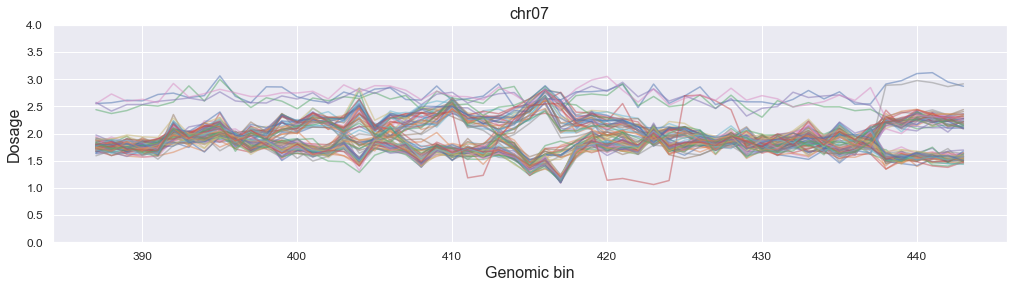

In [21]:
# This cell plots a single chromosome, displaying its dosage profile and identifying the span in bins
sns.set()
#'.k',markersize=12,   <- add to plot if needed
# ENTER CHROM NUMBER HERE
chrom = 7
# turn into string accounting for single and double digit entries
if len(str(chrom))== 2:
    chrom = 'chr'+str(chrom)
else:
    chrom = 'chr0'+str(chrom)
plo_chr = pop_main.where(pop_main['Bin'].str.contains(chrom))
# set figure size proportional to chromosome length 
chrom_len = df_val.at[chrom,'Chrom']
# the figsize reflects the size of chromosome. It is scaled to make the longest chrom
# about 15 long --YOU MAY NEED TO ADJUST fig_len VALUE TO YOUR DATA--
fig_len = chrom_len*3/10
plt.figure(figsize=(fig_len,4))
# OR, one could choose to make all figures the same
#plt.figure(figsize=(15,4))
# note the alpha (transparency). I prefer to set <1 to highlight mass trends
plt.plot(plo_chr.iloc[:,1:], alpha = 0.5)
# set labels and title as desired
plt.xlabel('Genomic bin', fontsize=16)
plt.ylabel('Dosage', fontsize=16)
plt.title(chrom, fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
# change to zoom in
plt.ylim(0,4)
# save as pdf, this makes it scalable in a vector program
plt.savefig(pop_name+'_chr'+chrom+'_'+today+'.pdf')
plt.show()

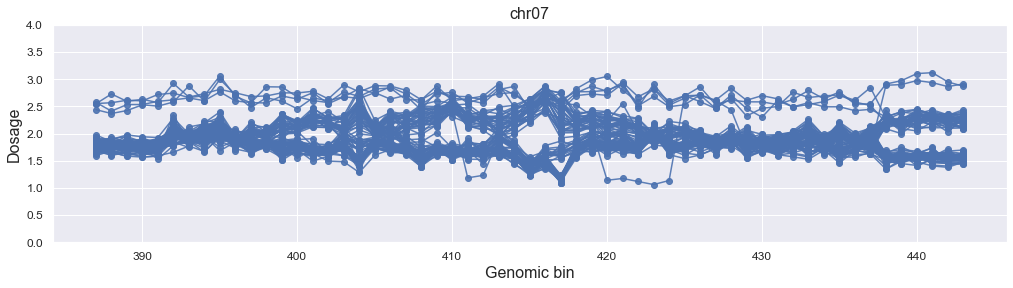

In [35]:
# This cell plots a single chromosome, displaying its dosage profile and identifying the span in bins
sns.set()
#'.k',markersize=12,   <- add to plot if needed
# ENTER CHROM NUMBER HERE
chrom = 7
# turn into string accounting for single and double digit entries
if len(str(chrom))== 2:
    chrom = 'chr'+str(chrom)
else:
    chrom = 'chr0'+str(chrom)
plo_chr = pop_main.where(pop_main['Bin'].str.contains(chrom))
# set figure size proportional to chromosome length 
chrom_len = df_val.at[chrom,'Chrom']
# the figsize reflects the size of chromosome. It is scaled to make the longest chrom
# about 15 long --YOU MAY NEED TO ADJUST fig_len VALUE TO YOUR DATA--
fig_len = chrom_len*3/10
plt.figure(figsize=(fig_len,4))
# OR, one could choose to make all figures the same
#plt.figure(figsize=(15,4))
# note the alpha (transparency). I prefer to set <1 to highlight mass trends
plt.plot(plo_chr.iloc[:,1:], 'ob-', alpha = 0.9)
# set labels and title as desired
plt.xlabel('Genomic bin', fontsize=16)
plt.ylabel('Dosage', fontsize=16)
plt.title(chrom, fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
# change to zoom in
plt.ylim(0,4)
# save as pdf, this makes it scalable in a vector program
# plt.savefig(pop_name+'_chr'+chrom+'_'+today+'.pdf')
plt.show()

## Chromosome dosage plot
The dosage value of different inviduals are overplotted to show trends. The plot allows the identification of dosage polymorphic bins

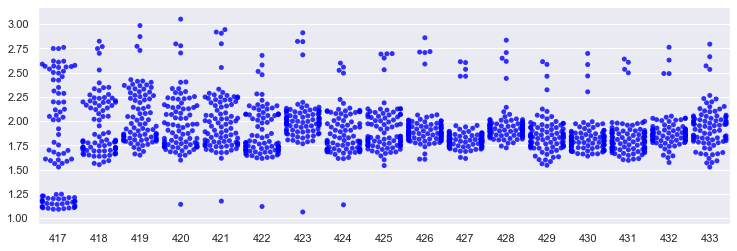

In [36]:
# BIN viewer graph
# it requires a native standard pop_main table, as of end of Step 1
# in steps below the df is executed further, new columns are added 
# choose bin and test quickly by displaying swarmplot of it and flanking bins
# keep flanking bins below 20 to avoid messy plots
# ---SET VALUES---
flanking_bins = 8
chr_bin = 425
# ----------------
sns.set()
# run a iloc to select pertinent part of df if notebook is further executed
#lope = pop_main.iloc[:,:-3]
lope = pop_main
bracket = lope.iloc[chr_bin-flanking_bins:chr_bin+flanking_bins+1,1:]
# run this line instead is the notebook is not executed below this cell
#bracket = lop.iloc[chr_bin-flanking_bins:chr_bin+flanking_bins+1,1:]
# transpose the data to create columns based on each bin
bracket = bracket.transpose()
# figure size is set by flanking bins, but capped at 17
fig_len = flanking_bins * 1.3 + 2
# limit size of fig_len
if fig_len < 17:
    fig_len
else:
    17
plt.figure(figsize=(fig_len,4))
ax = sns.swarmplot(data = bracket, alpha = 0.8, color = 'blue')


In [140]:
# enter chrom_bin number for testing behavior of peak finder
# Warning: mind execution state: if lop is executed, run "lope" lines above and changed here as indicated
# bin number is the index value. For example, the first bin of 
# chr 1, bin 1 has index 0
# USE this if the previous cell did not run!
#chr_bin = 1953
# set micropeak suppression. This is very important because it determines what happens 
# to minor peaks. 7 may be too high. My first run was with 3, probably a decent choice
# not a perfect one. 2 seems okay with large populations (~100)
# IMPORTANT: test the effect of this on multiple bins before changing
# for small populations set at 1.5
upeak_sup = 1.5
# change lop->lope if postexecuted
# count instances by binning, drop last value of bin to equalize x and y values
count_prel, division = np.histogram(pop_main.iloc[chr_bin,1:].values, bins= cluster_counts_x)
# change lop->lope if postexecuted
print(pop_main.iloc[chr_bin][0])
# smooth with savistky-golay. Jags (ranges with multiple peaks) proved to be impossible to deal with...
count_sg = savgol_filter(count_prel, 5, 3) 
# add noise to count, results in ([[object]]), index[0] to get simple array
count_noise = count_sg + noise[0]*0.1
# set to zero small signals with value 2 or smaller. This is done to avoid micro peaks and valleys.
count = np.where(count_noise>=upeak_sup,count_noise,0)
print(count_sg, len(count))
print(division, len(division))

chr07_48000001
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.17142857  0.51428571  1.05714286
  3.02857143  7.08571429 11.57142857  9.54285714  5.14285714  2.97142857
  5.94285714  7.62857143  9.54285714  8.37142857  5.85714286  1.82857143
  0.25714286 -0.25714286  0.34285714  0.48571429  0.34285714 -0.25714286
  0.6         1.31428571  1.17142857  0.17142857 -0.08571429  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.   

Text(0.5, 1.0, 'bin value')

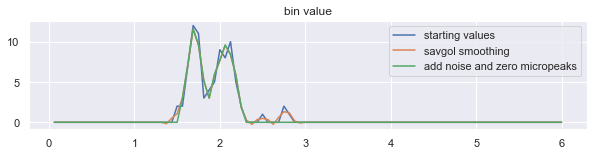

In [141]:
# apply savoy golitsky filter to smooth distribution
count_sg = savgol_filter(count_prel, 5, 3) 
plt.figure(figsize = (10,2))
plt.plot(division[1:], count_prel, label = "starting values")
plt.plot(division[1:], count_sg, label = "savgol smoothing")
plt.plot(division[1:], count, label = "add noise and zero micropeaks")
plt.legend()
plt.title("bin value")

[26 32]
[11.5857639   9.58847218] [1.6875 2.0625]


Text(0.5, 1.0, 'Peaks')

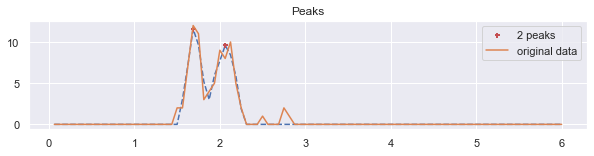

In [142]:
# indexing the peaks using the peakutils library
# note pop 475 gives too many peaks unless min_dist>3
# actual run uses thres=0.05, min_dist=4
peaks = peakutils.indexes(count, thres = 0.05, min_dist = 4)
# indexes of the peak value
print(peaks)
# peak count, peak position
print(count[peaks], division[1:][peaks])
plt.figure(figsize = (10,2))
pplot(division[1:], count, peaks)
plt.plot(division[1:], count_prel, label = 'original data')
plt.legend()
plt.title('Peaks')

In [143]:
# determining the data type
print(division[1:][peaks], peaks)
print(type(peaks))

[1.6875 2.0625] [26 32]
<class 'numpy.ndarray'>


In [144]:
# peakutils can find the valley by flipping the plot, so to say. This does not work well
# if the valleys are flat and wide as often they are in these data sets. 
# I decided to define the bottom of the valley as the 
# midplace between the peaks
lst = list()
for i in range(len(peaks)):
    if i == 0:
        lst.append(int(peaks[0]/2))
    else:
        lst.append(int((peaks[i]+peaks[i-1])/2))
lst.append(int((peaks[i]+linspace_divisions)/2))
valleys_mid = np.array(lst)
valleys_mid

array([13, 29, 64])

[ 4  9 16 21 29 37 41 46 53 57 61 69 75 79 82 87 92]
[0.         0.         0.         0.         3.01289477 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ] [0.3125 0.625  1.0625 1.375  1.875  2.375  2.625  2.9375 3.375  3.625
 3.875  4.375  4.75   5.     5.1875 5.5    5.8125]


Text(0.5, 1.0, 'Valleys')

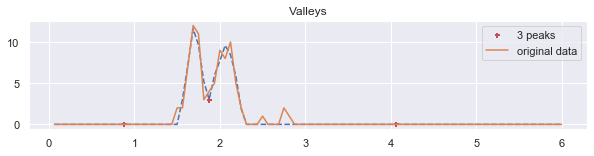

In [145]:
# indexing the valleys, note that min distance is based on histogram bin unit
valleys = peakutils.indexes(-count_noise, thres = 0.05, min_dist=2)
print(valleys)
print(count[valleys], division[1:][valleys])
left = np.searchsorted(valleys, peaks[0])-1
right = np.searchsorted(valleys, peaks[-1])+1
valleys_pruned = valleys[left:right]
plt.figure(figsize = (10,2))
pplot(division[1:], count, valleys_mid)
plt.plot(division[1:], count_prel, label = 'original data')
plt.legend()
plt.title('Valleys')
# valley bottoms are called "peaks" in the plot

In [146]:
# summary of bin analysis
print(peaks, valleys_mid)
print(division[peaks], division[valleys_mid])

[26 32] [13 29 64]
[1.625 2.   ] [0.8125 1.8125 4.    ]


In [147]:
# make a QC tool:
# make a function to test peaks and valley by the simple assumption that Valleys = 1 + Peaks
# this tool is used in trouble shooting. You can safely ignore it for routine use
def peak_tester(picchi, valli, chr_bin, i):
    if len(picchi)+1 != len(valli):
        print("peaks: ", picchi, "; valleys: ", valli, ";  chrom_bin: ", chr_bin, "; Index: ", i)
    else:
        pass
#   elif len(peaks) == 0:
        #print("faulty peaks: ", peaks, "; faulty valleys: ", valleys, "  Chrom_bin: ", chr_bin, "; Index: ", i)
    #elif len(valleys) > len(peaks)+1:
        #print("faulty peaks: ", peaks, "; faulty valleys: ", valleys, "  Chrom_bin: ", chr_bin, "; Index: ", i)

len(pop_main.index)

731

### Summary of parameter setting
The problem of extracting the peaks and valley proved moderately challenging. No solution was such to create a seamless Peak-Valley-Peak outcome when using PeakUtils valley finding method. In PeakUtilis the valleys are searched independently of peaks by flipping the plot (see peakutils documentation: https://peakutils.readthedocs.io/en/latest/). This solution would work well to analyze a wave-like response where valleys and peaks are similarly shaped. However, in the case of genome dosage states, peaks or clusters are often separated by flat "plains". Finally, the solution that made the most sense was to optimize the peak search and define valleys as places between peaks. Summarizing the process
1. Optimize peak search
    1. Smooth with savistky-golay algorithm (https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html)
    2. To avoid micro peaks and valleys, set to zero any small signal such as =<2. 
    3. Add random noise to count to avoid flat mesas
2. Define valleys as half-way between peaks, or between start and first peak


# Step 3. Analysis of dosage table

In [148]:
# Use above method to search each bin in the input table and add three columns,
# Peaks, Valleys, and Count of peaks. Bins with Count=1 are not CNV
# initialize list for valleys and peaks
ls_valleys = list()
ls_peaks = list()

for i in range(len(pop_main.index)):
    # generate histogram function
    count_prel, division = np.histogram(pop_main.iloc[i,1:].values, bins=cluster_counts_x)
    # add noise to count to avoid flat mesa peaks, results in ([[object]]), index[0] to get simple array
    count_noise = count_prel + noise[0]*0.1
    # smooth. Jags in function proved to be impossible to deal with...
    count_sg = savgol_filter(count_noise, 11, 5) 
    # set to zero signals smaller than 2. Note that noise was added and 2 became 2 + random_number<1
    count = np.where(count_sg>=2,count_sg,0)
    peaks = peakutils.indexes(count, thres=0.05, min_dist=4)
    # find valleys by the mid-value method
    # make temp list to hold processed valleys
    lst = list()
    for k in range(len(peaks)):
        if k == 0:
            lst.append(int(peaks[0]/2))
        else:
            lst.append(int((peaks[k]+peaks[k-1])/2))
    lst.append(int((peaks[k]+80)/2))
    # convert list back to array. Sexy? no. Effective? yes
    valleys_mid = np.array(lst)
    peak_tester(peaks, valleys_mid, pop_main.iloc[i,0],i)
    ls_valleys.append(division[valleys_mid])
    ls_peaks.append(division[peaks])
                      
print(len(ls_valleys), len(ls_peaks))
# Add the valleys and peaks identified as new columns to the lop dataframe
ls_n_peaks = [len(i) for i in ls_peaks]
pop_main['peaks'] = ls_peaks
pop_main['valleys'] = ls_valleys
pop_main['n_peaks'] = ls_n_peaks
pop_main.head()


731 731


,Bin,10,102,110,116,119,12,158,163,167,...,38,41,51,56,60,85,92,peaks,valleys,n_peaks
0,chr01_1,2.092527,2.092727,1.958804,2.106958,2.085891,2.201892,2.164737,1.939870,1.817495,...,1.948398,2.291332,2.286476,2.282991,2.214389,2.231603,1.938393,[2.0],"[1.0, 3.5]",1
1,chr01_1000001,1.897634,1.992515,1.930888,1.876096,1.839949,1.890621,1.966854,1.992071,1.936170,...,1.844095,1.951093,1.999530,2.064906,1.929031,1.974855,1.971926,[1.9375],"[0.9375, 3.4375]",1
2,chr01_2000001,1.936323,1.772452,1.756655,1.871713,1.854947,1.913907,1.831408,1.880172,1.915661,...,1.893202,1.989300,1.978932,1.977100,1.925121,1.872328,1.919441,[1.875],"[0.9375, 3.4375]",1
3,chr01_3000001,1.789378,1.832632,1.867571,1.862491,1.911370,1.965331,2.128080,1.892276,1.860424,...,1.817245,1.877267,1.908174,1.967944,2.070008,1.894124,2.043170,[1.875],"[0.9375, 3.4375]",1
4,chr01_4000001,2.138072,2.130775,1.998562,2.231837,1.962093,2.138677,2.269630,2.087952,2.004899,...,2.137419,2.189273,2.209824,2.238846,2.043964,2.073360,2.061816,[2.0625],"[1.0, 3.5]",1


In [149]:
#looking at one row:
pop_main.iloc[15,1:].values[:10]


array([1.7257213490342098, 1.58799232316369, 1.6951668356327,
       1.7059203405627, 2.4508561609212403, 2.61346513752154,
       1.79286240383941, 2.35614332123071, 2.52814771417727,
       2.62951631260947], dtype=object)

In [150]:
pop_main.to_pickle(pop_name+'_main_stdval_peaks_npeaks_upeak=1.5_'+today+'.pckle')
# for the purpose of re-using this table in pandas
# must use pickle or we lose the commas in the peak lists

In [151]:
# determine the number of bins by peak count
pop_main['n_peaks'].value_counts()


1    483
2    196
3     46
4      6
Name: n_peaks, dtype: int64

In [152]:
# make a new dataframe that has only the original values for plotting and analysis purposes
pop_d = pop_main.drop(["Bin", "valleys", "peaks", "n_peaks"], axis = 1)
pop_d.tail()


,10,102,110,116,119,12,158,163,167,179,...,320,35,36,38,41,51,56,60,85,92
726,1.903961,1.808712,2.529873,1.876449,1.790361,1.751914,1.915906,1.822728,1.958115,1.884179,...,1.960395,1.837360,1.885652,1.739343,1.850312,1.920692,1.957690,1.832067,1.748774,1.842186
727,1.914323,1.884457,2.789648,1.984584,1.827867,1.907901,1.944359,1.895388,1.897969,1.996169,...,1.897825,1.859020,1.907778,1.831358,2.003414,1.932789,2.158824,1.821830,1.763779,2.012474
728,1.937084,1.984487,2.828050,1.925078,1.795305,1.953695,2.014426,1.886444,1.933432,1.951245,...,2.029670,1.945355,1.783318,1.869280,2.012209,2.077032,1.949809,1.888111,1.935946,1.899571
729,1.728489,1.911082,2.698927,1.915783,1.866220,1.857041,1.871470,1.800214,2.059558,1.924325,...,2.001475,1.863389,1.869072,1.761432,1.952206,1.845332,1.887523,1.767194,1.750232,1.886222
730,1.851175,1.942021,2.486928,1.670817,1.794902,1.626226,1.825280,2.049991,1.811624,1.665061,...,1.777201,1.654671,1.745245,1.511402,1.713726,1.675515,1.804523,1.753683,1.718266,1.880901


In [153]:
# make a new df to store the cluster identities. 
pop_cluster = pop_main.iloc[:,:1]
pop_cluster.head()


,Bin
0,chr01_1
1,chr01_1000001
2,chr01_2000001
3,chr01_3000001
4,chr01_4000001


In [154]:
# test method to assign CNV value to cluster
# use searchsorted to assign each CNV value to the cluster
# the -2 index column on lop is the valley list, such as: [0.875, 2.0625, 3.625]
# searchsorted matches each value in a row to the valleys and assigns it
'''
value   valleys                index
2.391 [ 0.875   2.0625  3.625 ] 2
1.971 [ 0.875   2.0625  3.625 ] 1
2.127 [ 0.875   2.0625  3.625 ] 2
1.947 [ 0.875   2.0625  3.625 ] 1
'''
# very low or very high values would be given index 0 or 3. They would be outliers. 
# I considered opening the first and last valleys to include very low or very high
# values, but it does not seem right. In any case, the outliers do not matter in this
# analysis

# make a list of columns
ls_col = pop_d.columns
# test on the first row. Note that this bin has two peaks. 
for i in range(0,1):
    print(i)
    ls_index = []
    for j in pop_d[ls_col[i]]:
        pop_main.iloc[i,-2].searchsorted(j)
        # testing behavior
        print(j, pop_main.iloc[i,-2], pop_main.iloc[i,-2].searchsorted(j))
        

0
2.09252662942468 [1.  3.5] 1
1.8976340338138 [1.  3.5] 1
1.93632348526737 [1.  3.5] 1
1.7893778881015 [1.  3.5] 1
2.13807212449816 [1.  3.5] 1
1.80125473714358 [1.  3.5] 1
1.70672768246436 [1.  3.5] 1
1.6399824107338998 [1.  3.5] 1
1.95864527921275 [1.  3.5] 1
1.29353784042524 [1.  3.5] 1
1.46270186354831 [1.  3.5] 1
1.58602031808229 [1.  3.5] 1
1.58109558451296 [1.  3.5] 1
1.8315068619413104 [1.  3.5] 1
1.8899638486456696 [1.  3.5] 1
1.7257213490342098 [1.  3.5] 1
2.1465924922458703 [1.  3.5] 1
2.01374304733897 [1.  3.5] 1
1.90242314671144 [1.  3.5] 1
1.55492403465849 [1.  3.5] 1
1.9558799730558705 [1.  3.5] 1
2.186132751151 [1.  3.5] 1
1.5394188702250702 [1.  3.5] 1
1.63072315862946 [1.  3.5] 1
1.52081513776138 [1.  3.5] 1
2.09425734312564 [1.  3.5] 1
2.3861917972721 [1.  3.5] 1
1.82497764348221 [1.  3.5] 1
2.37547376254861 [1.  3.5] 1
2.7687317089852 [1.  3.5] 1
1.5055356889475602 [1.  3.5] 1
1.61888969270808 [1.  3.5] 1
1.4460810640156103 [1.  3.5] 1
1.4572595192542 [1.  3.5] 1
1

1.7210474050475402 [1.  3.5] 1
1.7639435951654698 [1.  3.5] 1
1.24016607771733 [1.  3.5] 1
1.19441645056386 [1.  3.5] 1
1.16313479415163 [1.  3.5] 1
1.06632751573322 [1.  3.5] 1
1.2086566105148702 [1.  3.5] 1
1.5807923938487398 [1.  3.5] 1
1.75131756198374 [1.  3.5] 1
1.74846607994389 [1.  3.5] 1
1.82346386308027 [1.  3.5] 1
1.7696009341208 [1.  3.5] 1
1.83708988766156 [1.  3.5] 1
1.89946353413426 [1.  3.5] 1
1.73834628530847 [1.  3.5] 1
1.81594534051938 [1.  3.5] 1
1.81495350401388 [1.  3.5] 1
1.96657993558288 [1.  3.5] 1
2.01328870479684 [1.  3.5] 1
1.90714580409457 [1.  3.5] 1
1.9058557229986497 [1.  3.5] 1
1.81935244442081 [1.  3.5] 1
1.89953383404502 [1.  3.5] 1
1.94049773023895 [1.  3.5] 1
1.98435247381211 [1.  3.5] 1
2.03439526088437 [1.  3.5] 1
1.8847431984715 [1.  3.5] 1
1.95532895348447 [1.  3.5] 1
1.7763874391729702 [1.  3.5] 1
2.1038657225150903 [1.  3.5] 1
1.69521644311992 [1.  3.5] 1
1.96745297063062 [1.  3.5] 1
2.04176683055401 [1.  3.5] 1
2.00916062385606 [1.  3.5] 1
1.

In [155]:
# this is the full run
# use searchsorted to assign each CNV value to the cluster 
# make a list of columns from df that has only values
ls_col = pop_d.columns
# derive the cluster membership of each value
# iterate from column to column
for col in ls_col:
    # make a list to store the clustering assignment
    ls_index = []
    # iterate down the column
    for j in range(len(pop_d[col])):
        # x.searchsorted(y) = find index of y in x series
        ls_index.append(pop_main.iloc[j,-2].searchsorted(pop_d[col][j]))
    pop_cluster[col] = ls_index
pop_cluster.head()


,Bin,10,102,110,116,119,12,158,163,167,...,320,35,36,38,41,51,56,60,85,92
0,chr01_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,chr01_1000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,chr01_2000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,chr01_3000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,chr01_4000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [156]:
#lop_cluster.head()
#write df to file
pop_cluster.to_csv(pop_name+'_cnv_upeak=1.5_'+today+'.csv', index=False)


In [157]:
# copy lop_cluster 
pop_clus = pop_cluster.copy()
pop_clus.head()


,Bin,10,102,110,116,119,12,158,163,167,...,320,35,36,38,41,51,56,60,85,92
0,chr01_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,chr01_1000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,chr01_2000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,chr01_3000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,chr01_4000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [158]:
# make a df out of the n_peaks column of lop for joining to another df
popp = pop_main.loc[:,"n_peaks"]
popp.head()


0    1
1    1
2    1
3    1
4    1
Name: n_peaks, dtype: int64

In [159]:
popp.max()


4

In [160]:
pop_clus = pd.concat([pop_clus, popp], axis=1 )
pop_clus.head()

,Bin,10,102,110,116,119,12,158,163,167,...,35,36,38,41,51,56,60,85,92,n_peaks
0,chr01_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,chr01_1000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,chr01_2000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,chr01_3000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,chr01_4000001,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


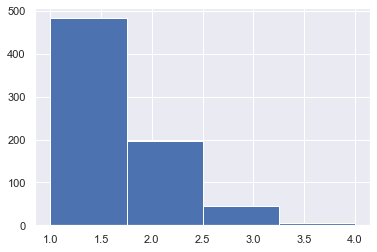

In [161]:
# plot the distribution of bins by peak number
pop_clus['n_peaks'].hist(bins = popp.max())


In [162]:
pop_clus.shape


(731, 86)

In [163]:
#drop the rows that have all 1, i.e. filter the df to keep rows that are polymorphic 
pop_clus = pop_clus[pop_clus['n_peaks']>1]
pop_clus.shape


(248, 86)

In [164]:
#drop the column used for filtering
pop_clus = pop_clus.drop('n_peaks', axis = 1)
#set the index to bin
pop_clus.set_index('Bin', inplace = True)
pop_clus.head()


,10,102,110,116,119,12,158,163,167,179,...,320,35,36,38,41,51,56,60,85,92
Bin,,,,,,,,,,,,,,,,,,,,,
chr01_9000001,1,2,2,2,3,2,2,3,2,2,...,1,2,2,2,2,2,1,2,1,1
chr01_10000001,1,2,2,2,3,2,2,3,3,2,...,1,3,2,2,2,2,1,2,1,1
chr01_11000001,1,1,1,1,2,2,1,2,2,2,...,1,2,1,1,1,1,1,1,1,1
chr01_13000001,1,1,1,1,2,2,1,2,2,2,...,1,2,1,1,1,1,1,1,1,1
chr01_14000001,2,2,2,2,3,3,2,3,3,3,...,1,3,1,1,2,1,1,2,1,1


# Run chi-sq and fisher-exact tests
* prepare input table
* test algorithm
* run on large table

In [165]:
# SPECIAL CELL --Skip unless you want to filter table
# remove the individuals that display knopoped chromosomes
'''dropcols = ['0932', '0935', '0940', '0941', '0945', '0946', '0947', '0949', '0951', '0957', '0980', '0982', '0986', '0987', '0989']
pop_clus.drop(columns=dropcols, inplace=True)
pop_clus.head()'''

"dropcols = ['0932', '0935', '0940', '0941', '0945', '0946', '0947', '0949', '0951', '0957', '0980', '0982', '0986', '0987', '0989']\npop_clus.drop(columns=dropcols, inplace=True)\npop_clus.head()"

In [166]:
# prepare a transposed table. Each column will be a bin. This allows collection of clustered 
# lines for each bin
lcc2=pop_clus.copy()
lcc2=lcc2.T
lcc2.to_csv(pop_name+'_clusters_by_bin_'+today+'.csv')
lcc2.head()


Bin,chr01_9000001,chr01_10000001,chr01_11000001,chr01_13000001,chr01_14000001,chr01_15000001,chr01_18000001,chr01_19000001,chr01_20000001,chr01_21000001,...,chr12_42000001,chr12_43000001,chr12_44000001,chr12_45000001,chr12_46000001,chr12_47000001,chr12_48000001,chr12_50000001,chr12_51000001,chr12_52000001
10,1,1,1,1,2,1,2,1,1,2,...,1,1,1,1,1,1,1,1,1,1
102,2,2,1,1,2,1,1,1,1,2,...,3,2,3,3,4,3,2,2,2,1
110,2,2,1,1,2,1,1,1,1,1,...,3,2,2,3,2,3,2,2,2,2
116,2,2,1,1,2,1,1,1,1,2,...,1,1,1,1,1,1,1,1,2,1
119,3,3,2,2,3,2,2,2,2,2,...,2,2,2,1,2,3,2,1,2,1


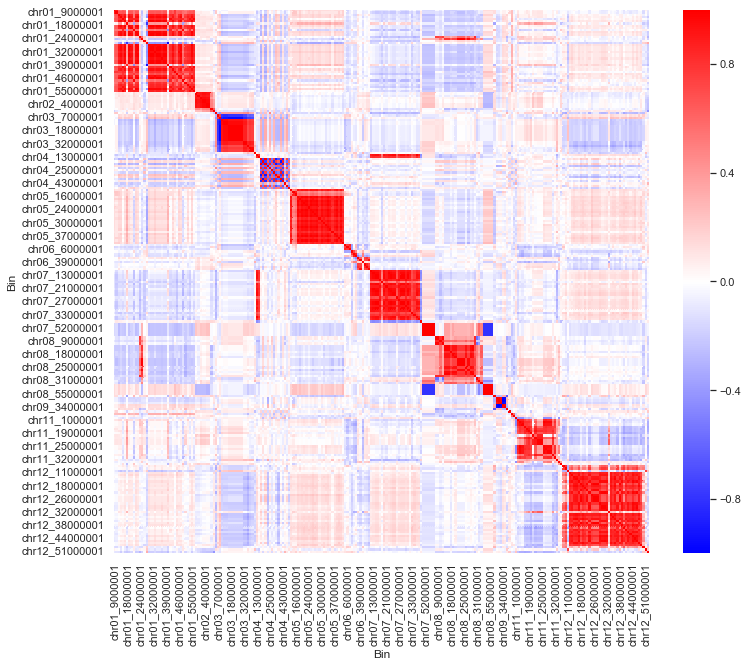

In [167]:
# let's take a quick peek at correlation matrix
# you should see a pattern of (red) correlated dots along the diagonal
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.heatmap(lcc2.corr(), cmap = "bwr")


In [169]:
#test nunique
# key provided here must be present in dataframe!
n_clusters = lcc2['chr01_9000001'].nunique()
#st = set(lcc2['chr01_1'][lcc2['chr01_1']==2].index)
for i in range(n_clusters):
    print(i+1)
    

1
2
3


In [170]:
#iterate through columns and construct a dict of sets: cluster name->set of lines
#cluster is designated as follows: chr01_1^1
cclustd = dict()
cols = lcc2.columns
#lcc2['chr01_1'].nunique()
#indexed when testing: example, cols[:10]
cols = cols
for col in cols:
    n_clusters = lcc2[col].nunique()
    # print(n_clusters)
    # iterate over each cluster type (1, 2 etc)
    for i in range(n_clusters):
        #print(i)
        # derive set of line names from the index of filtered columns
        temp_set = set(lcc2[col][lcc2[col]==i+1].index)       
        cclustd[col+'^'+str(i+1)]=temp_set
#len(cclustd)
key_ls = sorted(list(cclustd))


In [171]:
lcc2.shape

(84, 248)

### The big run (so to say)
This is the step that takes the most time. On a 2016-late macbook pro using an input 167x380 dataframe, this takes ~1 hour to run. If your input dataframe is very large, you may want to run this on a server or use other computational tricks to shorten it. You can estimate the time it will take by testing how long it takes to run a smaller version of your dataframe, such as substituting `cols = cols[:10]` for `cols = cols` below. This limits the total columns to the first 10 and allows an estimation of time. 

In [172]:
# for each chrom bin compare the sets of lines in each cluster with all the other clusters
cols = lcc2.columns
# set columns to few for testing, cols = cols[:5], or set to cols = cols
cols = cols
mylin = len(lcc2.index)
lcc_chisq_ls = [['chr_bin', 'chr', 'bin', 'cluster','target_chr_bin', 'target_chr', 'target_bin', 'target_cluster', 'p', 'rel',
                 'obs_set1', 'lenset2', 'obs_matching_set2', 'obs_notmatching_set2', 'exp_matching_set2', 'exp_notmatching_set2'],] 
counter = 0
counter_of_comparisons = 0
for col in cols:
    counter += 1
    # set printing interval for progress counter. This avoids excessive printing. Set it to an informative interval
    print_interval=10
    # print progress at every "print interval"
    if counter%print_interval == 0:
        print("col_iteration "+str(counter)+',', 'remaining iterations: '+str(len(cols)-counter))
    else:
        pass
    # pick the cluster from which set 1 will come
    n_clusters = lcc2[col].nunique()
    #print('number of clusters in first bin:', n_clusters)
    for i in range(n_clusters):
        # pick a set, example:'chr11_29000001^2'
        myset1 = cclustd[col+'^'+str(i+1)]
        # observed in cluster that sets hypothesis
        obs_in_myset1 = len(myset1)
        # compare it to the rest of cluster sets
        # size of starting cluster/total 
        myexpect_ratio = obs_in_myset1/mylin
        # change name of col variable to avoid ambiguity
        for col2 in cols:
            # get a new n_clusters and change name
            n_clusters2 = lcc2[col2].nunique()
            #print(n_clusters2)
            # go through the sets, using a different variable than i
            for j in range(n_clusters2):
                #print('number of clusters in target bin:', n_clusters2)
                # pick a comparison cluster
                myset2 = cclustd[col2+'^'+str(j+1)]
                lenset2 = len(myset2)
                #print("len of set2", len(myset2))
                # observed matching:how many from the starting set are in the second set
                obsm_in_myset2 = len(myset1.intersection(myset2))
                #print("matching set2", obsm_in_myset2)
                #if obsm_in_myset2 == 0:
                    #print("mset 0. Len of target set is:",len(myset2),"Len of ref set is:", obs_in_myset1)
                    #print("target set:",myset2,"ref set:", myset1)
                #else:
                    #pass
                # observed not matching: how many additional lines are in set 2
                obsnm_in_myset2 = len(myset2)-obsm_in_myset2
                expm_in_myset2 = len(myset2)*myexpect_ratio
                expnm_in_myset2 = len(myset2)-expm_in_myset2
                if obsm_in_myset2 > expm_in_myset2:
                    rel = "pos"
                elif obsm_in_myset2<expm_in_myset2:
                    rel = "neg"
                # list for chisq: [observed, expected]
                result = stats.fisher_exact([[obsm_in_myset2, obsnm_in_myset2], [int(expm_in_myset2), int(expnm_in_myset2)]])
                p = result[1]
                counter_of_comparisons+=1
                if p <= 0.05:
                    ls_toappend = [col, col[3:5], col.split('_')[1],  i+1, col2, col2[3:5], col2.split('_')[1],  j+1, p, rel,
                               obs_in_myset1, lenset2, obsm_in_myset2, obsnm_in_myset2, int(expm_in_myset2), int(expnm_in_myset2)]
                    lcc_chisq_ls.append(ls_toappend)
                else:
                    continue
# copy the list into a new dataframe
fisher_pop_df = pd.DataFrame(lcc_chisq_ls[1:], columns=lcc_chisq_ls[0])
# all self comparisons will be highly correlated and will pass stat test
all_with_selfs = fisher_pop_df.shape[0]
print("passing comparisons including to self:", all_with_selfs)
# eliminate same bin comparisons 
fisher_pop_df = fisher_pop_df[fisher_pop_df['chr_bin']!= fisher_pop_df['target_chr_bin']]
print("total number of comparisons:", counter_of_comparisons)
print("passing comparisons between different bins:", fisher_pop_df.shape[0])
self_comps = all_with_selfs - fisher_pop_df.shape[0]
print("self comparisons:", self_comps)
fisher_pop_df.to_csv('fisher_'+pop_name+'_upeak=2_'+today+'.csv', index=False)  
# set number of fake comparisons to be added to p's for bh procedure (make up set = mus)
mus = (counter_of_comparisons - self_comps)/2 - fisher_pop_df.shape[0] + self_comps
print('make up set(mus)='+str(mus))
# this program will print out iterations done and remaining to indicate progress
# from this, you can estimate the time required

col_iteration 10, remaining iterations: 238
col_iteration 20, remaining iterations: 228
col_iteration 30, remaining iterations: 218
col_iteration 40, remaining iterations: 208
col_iteration 50, remaining iterations: 198
col_iteration 60, remaining iterations: 188
col_iteration 70, remaining iterations: 178
col_iteration 80, remaining iterations: 168
col_iteration 90, remaining iterations: 158
col_iteration 100, remaining iterations: 148
col_iteration 110, remaining iterations: 138
col_iteration 120, remaining iterations: 128
col_iteration 130, remaining iterations: 118
col_iteration 140, remaining iterations: 108
col_iteration 150, remaining iterations: 98
col_iteration 160, remaining iterations: 88
col_iteration 170, remaining iterations: 78
col_iteration 180, remaining iterations: 68
col_iteration 190, remaining iterations: 58
col_iteration 200, remaining iterations: 48
col_iteration 210, remaining iterations: 38
col_iteration 220, remaining iterations: 28
col_iteration 230, remainin

In [173]:
print("passing comparisons including to self:", all_with_selfs)
# eliminate same bin comparisons 
print("total number of comparisons:", counter_of_comparisons)
print("passing comparisons between different bins:", fisher_pop_df.shape[0])
self_comps = all_with_selfs - fisher_pop_df.shape[0]
print("self comparisons:", self_comps)
# set number of fake comparisons to be added to p's for bh procedure (make up set = mus)
mus = (counter_of_comparisons - self_comps)/2 - fisher_pop_df.shape[0] + self_comps
print('make up set(mus)='+str(mus))


passing comparisons including to self: 22741
total number of comparisons: 316969
passing comparisons between different bins: 21513
self comparisons: 1228
make up set(mus)=137585.5


In [174]:
counter_of_comparisons

316969

If the notebook has been executed previously, closed, and reopened, you can reenter here by uploading the last saved .csv. The name should be approximately as indicated below. 

>fisher_lop_df = pd.read_csv('fisher_XX_date.csv')


In [175]:
# table dimension
fisher_pop_df.shape

(21513, 16)

# Multiple test correction
The formula for BH is P<i/m*Q, where i is the rank (low to high P), M is the number of tests and Q is the FDR, e.g 0.05 or 0.1. If operated manually, the program would calculates BH p using the length of the input list = the size of this table. The number of tests performed, however, is more. 

### Output stats from fisher exact run on whole set (using exemplary data, yours may differ)
* passing comparisons including to self: 22741
* tc = total number of comparisons: 316969
* passing comparisons between different bins: 21513
* self comparisons: 1228
* make up set(mus) = 137585
* sc = self comparisons: 2402

### How many independent comparisons?
The number of independent comparisons is a matter of debate, but it is less than the number of total comparison that were carried out above. Linked sites are not indedent, for example. In addition, different clusters in the same bin are also not independent. Last, each bin pair is examined twice, which is the only criterion of dependence that we accept here to be conservative. Therefore, we take all comparisons as independent except the double examination of bins pairs. Accordingly, we cut the number of independent comparisons (ic) to half of TC - the self comparisons:
* ic = (tc-sc)/2 = (316969-2402)/2 

To correct for BH, one would have to collect all probabilities from all comparison in the Eisher Exact loop test (step above). It is just as easy to make up the set of p's higher than 0.05. The length of the fake dataset to make and add to the BH calc is
* mus = ic - pc

In [176]:
# make an array of the P values for bh correction
# 08272017, to account for the multiple comparisons (see above) add N = MUS random datapoints
# in range 0.06, 0.99. I could have collected them during the FE procedure, but these values do not matter
# see http://www.biostathandbook.com/multiplecomparisons.html
datap = fisher_pop_df['p']
# make a list, fill it with floats in range
mls = list()
# mus is the precalculated number of fake p values for padding input p column
for i in range(int(mus)):
    mls.append(random.uniform(0.06,0.99))
datap = np.append(datap, np.asarray(mls))
#len(datap)
len(datap)


159098

In [177]:
print(len(datap), len(fisher_pop_df['p']))

159098 21513


In [178]:
# make sure to have this at starting cell: from statsmodels.api import stats as stt 
# run benjamini hochberg test using multipletests from statsmodels.stats (imported as stt)
# note that datap has "all" the independent comparisons (len of array of p values will vary depending on data)
# multipletests produces four items: two arrays, and two floats for sidak and bonferroni corrections
# SET FDR 
FDR = 0.05
a = stt.multipletests(datap, alpha = FDR, method = 'fdr_bh')
# the result is for the 0.5M input. The df is only 44k long. Truncate the bh analysis to fit.
#a[1]
#len(a)
fisher_pop_df['p_bh'] = a[1][:fisher_pop_df.shape[0]]
fisher_pop_df['fdr_0.05'] = a[0][:fisher_pop_df.shape[0]]
#fisher_lop_df.head()
fisher_pop_df.to_csv('fisher_'+pop_name+'_df_upeak2_with_bh_'+str(FDR)+'_'+today+'.csv', index=False)


In [179]:
datap[:15]


array([1.05210553e-05, 1.50838062e-02, 2.26175577e-02, 3.44379073e-02,
       2.29223765e-02, 2.29223765e-02, 2.29223765e-02, 2.34720592e-02,
       2.70901270e-02, 2.32065382e-02, 2.29223765e-02, 2.32065382e-02,
       2.29223765e-02, 2.29223765e-02, 2.34720592e-02])

In [180]:
a[1][:15]


array([2.17612955e-04, 1.31352129e-01, 1.86455681e-01, 2.68955119e-01,
       1.88597210e-01, 1.88597210e-01, 1.88597210e-01, 1.92304325e-01,
       2.17995297e-01, 1.90816777e-01, 1.88597210e-01, 1.90816777e-01,
       1.88597210e-01, 1.88597210e-01, 1.92304325e-01])

In [181]:
fisher_pop_df.describe()


,cluster,target_cluster,p,obs_set1,lenset2,obs_matching_set2,obs_notmatching_set2,exp_matching_set2,exp_notmatching_set2,p_bh
count,21513.000000,21513.000000,2.151300e+04,21513.000000,21513.000000,21513.000000,21513.000000,21513.000000,21513.000000,21513.000000
mean,1.672105,1.698740,5.694922e-03,37.901362,35.861619,16.275508,19.586111,15.871380,19.054897,0.047020
std,0.730359,0.738068,1.118035e-02,13.591776,13.554044,17.884770,18.271211,9.377608,9.553567,0.086987
min,1.000000,1.000000,7.967396e-09,6.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000005
25%,1.000000,1.000000,1.597268e-06,28.000000,27.000000,0.000000,1.000000,9.000000,13.000000,0.000047
50%,2.000000,2.000000,1.076861e-04,37.000000,36.000000,9.000000,16.000000,15.000000,18.000000,0.001591
75%,2.000000,2.000000,4.527335e-03,46.000000,45.000000,32.000000,34.000000,20.000000,23.000000,0.044617
max,4.000000,4.000000,4.990041e-02,75.000000,72.000000,72.000000,72.000000,64.000000,64.000000,0.369035


In [182]:
# store table using pickle to keep numbers as numbers
fisher_pop_df.to_pickle('fisher_'+pop_name+'_df_upeak2_with_bh_'+str(FDR)+'_'+today+'.pckle')


In [183]:
# make subtable of interchromosomal LD
fe_inter = fisher_pop_df[fisher_pop_df["chr"] != fisher_pop_df["target_chr"]]
print(fisher_pop_df.shape, fe_inter.shape)


(21513, 18) (1238, 18)


In [184]:
fe_inter.to_csv(pop_name+'_fe_interchr_'+today+'.csv', index = False)


In [185]:
fisher_pop_df.head()


,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,obs_set1,lenset2,obs_matching_set2,obs_notmatching_set2,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05
2,chr01_9000001,01,9000001,1,chr01_10000001,01,10000001,1,0.000011,pos,17,15,15,0,3,11,0.000218,True
3,chr01_9000001,01,9000001,1,chr01_10000001,01,10000001,2,0.015084,neg,17,53,2,51,10,42,0.131352,False
4,chr01_9000001,01,9000001,1,chr01_11000001,01,11000001,2,0.022618,neg,17,26,0,26,5,20,0.186456,False
5,chr01_9000001,01,9000001,1,chr01_14000001,01,14000001,1,0.034438,pos,17,34,15,19,6,27,0.268955,False
6,chr01_9000001,01,9000001,1,chr01_14000001,01,14000001,3,0.022922,neg,17,27,0,27,5,21,0.188597,False


In [186]:
fisher_pop_df['fdr_'+str(FDR)].value_counts()


True     16325
False     5188
Name: fdr_0.05, dtype: int64

In [187]:
fisher_pop_df.head()

,chr_bin,chr,bin,cluster,target_chr_bin,target_chr,target_bin,target_cluster,p,rel,obs_set1,lenset2,obs_matching_set2,obs_notmatching_set2,exp_matching_set2,exp_notmatching_set2,p_bh,fdr_0.05
2,chr01_9000001,01,9000001,1,chr01_10000001,01,10000001,1,0.000011,pos,17,15,15,0,3,11,0.000218,True
3,chr01_9000001,01,9000001,1,chr01_10000001,01,10000001,2,0.015084,neg,17,53,2,51,10,42,0.131352,False
4,chr01_9000001,01,9000001,1,chr01_11000001,01,11000001,2,0.022618,neg,17,26,0,26,5,20,0.186456,False
5,chr01_9000001,01,9000001,1,chr01_14000001,01,14000001,1,0.034438,pos,17,34,15,19,6,27,0.268955,False
6,chr01_9000001,01,9000001,1,chr01_14000001,01,14000001,3,0.022922,neg,17,27,0,27,5,21,0.188597,False


# Conclusions
We processed the standardized data set of CNV in the following way:
1. Prepared a CNV table for input
2. Used it to define a clustering method, i.e. a method to identify cnv values polymorphic in the population and to classify each individuals according to its cnv value across the genome
3. Compare the cnv state at one locus to that of all other loci to find linkage disequilibrium
4. Test the significance of LD and correct for multiple testing using the FDR method
5. The results are five tables (today is the date of output, XX is for the population name, ? for unknown digit):
  +  `XX_stdval_peaks_npeaks_today.csv`: cleaned up starting table
  +  `XX_clusters_by_bin_today.csv`: CN values are converted to peak id
  +  `fisher_XX_df_today.csv`: each row is a comparison between two peaks in two bins that passed the FE test with p of 0.05 or smaller
  +  `fisher_XX_df_with_bh_0.??_today.pckle`: adds two columns for adjusted BH p and boolean pass-no pass test for stated FDR
  +  `XX_fe_interchr_today.csv`: filters above table to interchromosomal comparisons
  
  